In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization


from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler




Using TensorFlow backend.


In [3]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/train.csv")

In [4]:
train.info()
train.head()
print(test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
(42000, 785)


In [5]:
X_train = train.drop(labels = ["label"], axis = 1)
Y_train = train['label']
test = test.drop(labels = ["label"], axis = 1)

Y_train.value_counts()


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

Text(0.5, 1.0, 'Count of digit classes')

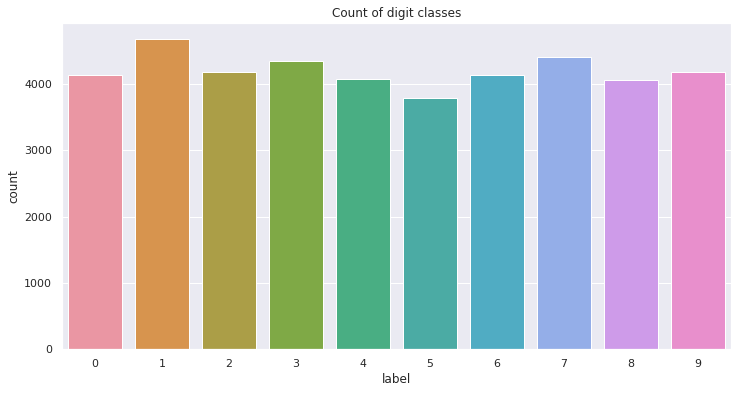

In [6]:
sns.set(style = "darkgrid", palette = "RdBu")
plt.figure(figsize = (12,6))
sns.countplot(Y_train)
plt.title("Count of digit classes")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


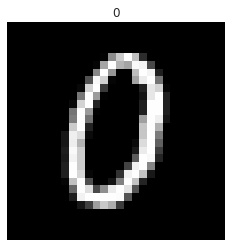

In [7]:
img = X_train.iloc[5].as_matrix()
img = img.reshape((28,28))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title(train.iloc[5,0])
plt.axis('off')
plt.show()

In [8]:
#checking for missing data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

**NORMALIZATION**

In [10]:
X_train = X_train / 255.0
test = test / 255.0
print("shape of test: ", test.shape)
print("shape of train: ", X_train.shape)

shape of test:  (42000, 784)
shape of train:  (42000, 784)


In [11]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)


x_train shape:  (42000, 28, 28, 1)
test shape:  (42000, 28, 28, 1)


In [12]:
from keras.utils.np_utils import to_categorical # convert to one-hot encoding
Y_train = to_categorical(Y_train, num_classes = 10)

A number i gets mapped to $e_i,$ i.e., 3 $\to$ [0,0,0,1,0,0,0,0,0,0]

__Train Test Split__

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

In [14]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_val.shape)
print("Y_train shape: ", Y_train.shape)
print("Y_test shape: ", Y_val.shape)

X_train shape:  (37800, 28, 28, 1)
X_test shape:  (4200, 28, 28, 1)
Y_train shape:  (37800, 10)
Y_test shape:  (4200, 10)


Train and test data is split to 90%--10% ratio.

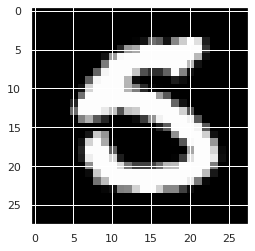

In [15]:
# Image example
plt.imshow(X_train[4][:,:,0],cmap='gray')
plt.show()


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [34]:
model = Sequential()
model.add(Conv2D(filters = 8 , kernel_size = (5,5), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 16 , kernel_size = (5,5), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))
model.add(MaxPool2D(pool_size = (2,2), strides = None))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 16 , kernel_size = (3,3), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32 , kernel_size = (3,3), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))
model.add(MaxPool2D(pool_size = (2,2), strides = None))
model.add(Dropout(0.5))




model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 8)         208       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 16)        3216      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)        2320      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)         

**OPTIMIZER**

There are many optimizers that imporove gradient descent. I will briefly explain two of them -- RMSProp and Adam and then use the latter as my optimization algorithm.

Let $\omega^{[l]}$ and $b^{[l]}$ be (vectorized) wieghts and biases on the layer $l$ of a neural network. Conveniently, let us denote $\partial\omega^{[l},\ \partial b^{[l]}$ (though $\Delta $ would be a better notation for $\partial$) be the partial derivatives of the weights and the bias. 

In the standard batch gradient descent, we update (one 'epoch') the parameters as follows:
$$\omega^{[l]} = \omega^{[l]} - \alpha \ \partial\omega^{[l]},\ \ \ b^{[l]} = b^{[l]} - \alpha\  \partial b^{[l]},$$
where $\alpha$  is a learning rate.

In order to discuss other optimization algorithms, let us for convenience drop the superscripts $[l]$ on the weights  and biases but we keep in mind that the parameters are different on each layer.


**RMSProp**

RMSProp (root mean square prop) is an optimization algorithm developed by Geoffrey Hinton and it goes as follows.

Fix a parameter $0<\beta < 1,$ and set two initial parameters $s_{\partial\omega} = 0,\ s_{\partial b}=0 $. For each epoch, update the paremeters $s_{\partial\omega},\ s_{\partial b}$ as:
$$s_{\partial\omega} = \beta\  s_{\partial\omega} + (1-\beta)\  \partial\omega^2,\
\ s_{\partial b} = \beta\  s_{\partial b} + (1- \beta)\  \partial b^2.  \ \ \ \ \ (1)$$

Here $\omega^2$ and $b^2$ denote elementwise squaring. 

Then the parameters $\omega$ and $b$ are updated as follows:

$$\omega = \omega - \alpha\frac{\partial\omega}{\sqrt{s_{\partial\omega}}}, \ \ b = b-\alpha\frac{\partial b}{\sqrt{s_{\partial b}}}.$$

**Gradient descent with momentum**

This algorithm is similar to the above algorithm. We initialize $v_{\partial\omega} = 0, v_{\partial b} = 0,$ iterate them according to:

$$v_{\partial\omega} = \beta \ v_{\partial\omega} + (1-\beta)\  \partial\omega,\
\ v_{\partial b} = \beta\  v_{\partial b} + (1- \beta)\  \partial b.  \ \ \ \ \ (2)$$



Then the parameters $\omega$ and $b$ are updated as follows:

$$\omega = \omega - \alpha\ v_{\partial\omega}, \ \ b = b-\alpha\  v_{\partial b}.$$

Note that $\partial\omega,\ \partial b$ are replaces with $v_{\partial\omega},\  v_{\partial b}.$



**Adam **

The Adam algorithm is some sort of combination of RMSProp and Momentum gradient descent. We start with initializations $s_{\partial\omega} = 0,s_{\partial b}=0,v_{\partial\omega}=0,v_{\partial b}= 0,$ update $s_{\partial\omega} = 0,s_{\partial b}=0$ as in the equation (1) (RMSProp) with parameter $0<\beta_1 <1$ and update $v_{\partial\omega} = 0,v_{\partial b}=0$ as in equation (2) (Momentum) with parameter $0<\beta_2< 1.$
Before starting the gradient descent we first do a "bias correction" on each iterate $t$ as follows:
$$s_{\partial\omega}\to \frac{s_{\partial\omega}}{1-\beta_1^t},\ \ s_{\partial b}\to \frac{s_{\partial b}}{1-\beta_1^t}$$
and

$$v_{\partial\omega}\to \frac{v_{\partial\omega}}{1-\beta_2^t},\ \ v_{\partial b}\to \frac{v_{\partial b}}{1-\beta_2^t}.$$

We then update the parameters $\omega$ and $b$ as:

$$\omega = \omega - \alpha\ \frac{v_{\partial\omega}}{\sqrt{s_{\partial\omega}} + \varepsilon}, \ \ b = b-\alpha\ \frac{ v_{\partial b}}{\sqrt{s_{\partial b}} + \varepsilon}.$$


**The choice of hyperparameters.**

Thee learning rate have to be tuned. According to Andrew Ng's Machine Learning course, the best choice for the hyperparameters
$\beta_1\ \beta_2, \ \varepsilon$ are $0.9,\ 0.999,\ 10^{-8}.$ These are set by default on Keras and we will choose these parameters for our optimization hyperparameters.

















In [35]:
# define the optimizer
optimizer = Adam(learning_rate=0.001 )

In [36]:
# compile
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

Epochs and Batch Sizes

In [40]:
epochs = 20
batch_size = 128


In [41]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=0.5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.5, # Randomly zoom image 5%
        width_shift_range=0.5,  # randomly shift images horizontally 5%
        height_shift_range=0.5,  # randomly shift images vertically 5%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)



In [42]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size), 
                              epochs = epochs,
                              validation_data = (X_val, Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size
                             )

Epoch 1/20
295/295 [==============================] - 40s 136ms/step - loss: 1.0424 - accuracy: 0.6475 - val_loss: 0.1734 - val_accuracy: 0.9462
Epoch 2/20
295/295 [==============================] - 40s 135ms/step - loss: 1.0134 - accuracy: 0.6583 - val_loss: 0.1629 - val_accuracy: 0.9533
Epoch 3/20
295/295 [==============================] - 40s 136ms/step - loss: 0.9914 - accuracy: 0.6650 - val_loss: 0.1670 - val_accuracy: 0.9517
Epoch 4/20
295/295 [==============================] - 40s 136ms/step - loss: 0.9810 - accuracy: 0.6707 - val_loss: 0.1455 - val_accuracy: 0.9588
Epoch 5/20
295/295 [==============================] - 40s 135ms/step - loss: 0.9512 - accuracy: 0.6814 - val_loss: 0.1291 - val_accuracy: 0.9629
Epoch 6/20
295/295 [==============================] - 41s 138ms/step - loss: 0.9427 - accuracy: 0.6819 - val_loss: 0.1127 - val_accuracy: 0.9698
Epoch 7/20
295/295 [==============================] - 40s 137ms/step - loss: 0.9129 - accuracy: 0.6909 - val_loss: 0.1322 - val_ac

__Model Evaluation__

In [ ]:

plt.plot(history.history["val_loss"], color = 'g', label = "validation loss" )
plt.title("Loss function")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

**Confusion Matrix**

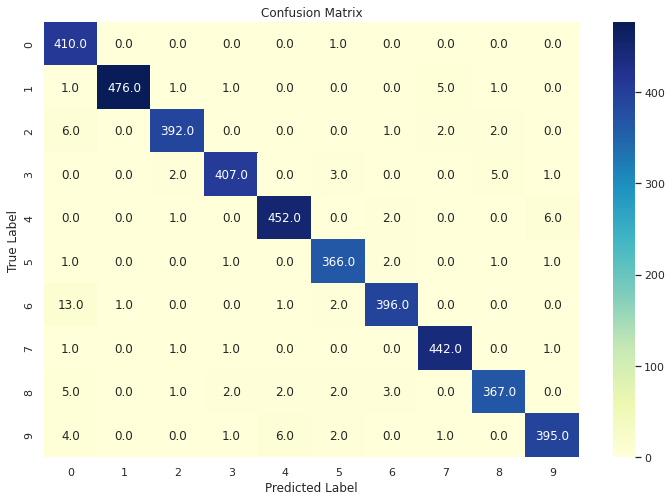

In [43]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_val)
Y_pred_class = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)
confusion = confusion_matrix(Y_true, Y_pred_class)


f, ax = plt.subplots(figsize= (12,8))
sns.heatmap(confusion, annot = True, cmap = "YlGnBu", ax = ax, fmt= '.1f')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()